In [1]:
from esm.models.esmc import ESMC
import pandas as pd
from glycowork.ml.inference import get_lectin_preds, get_esmc_representations
from glycowork.ml.models import prep_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from Bio import SeqIO

c:\Users\Logan\miniconda3\envs\glycan-summer-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
esm_model = ESMC.from_pretrained("esmc_300m")
leor = prep_model("LectinOracle", 1, trained = True)

Fetching 4 files: 100%|██████████| 4/4 [00:00<?, ?it/s]


Download completed.


## Load Data

In [3]:
glycan_df = pd.read_csv('data/Glycans-L-sugars-etc2.txt', sep='\t')
print(len(glycan_df))
glycan_df.head()

21


,Name,IUPAC
0,L-aGlc-Sp0,L-Glc(α-Sp0
1,L-bGlc-Sp0,L-Glc(β-Sp0
2,L-Man-Sp0,L-Man(α-Sp0
3,L-Rha-Sp0,Rha(α-Sp0
4,L-aGal-Sp0,L-Gal(α-Sp0


In [4]:
left_glycan_df = glycan_df[glycan_df['Name'].str.startswith('L-')].reset_index(drop=True)
print(len(left_glycan_df))
left_glycan_df

6


,Name,IUPAC
0,L-aGlc-Sp0,L-Glc(α-Sp0
1,L-bGlc-Sp0,L-Glc(β-Sp0
2,L-Man-Sp0,L-Man(α-Sp0
3,L-Rha-Sp0,Rha(α-Sp0
4,L-aGal-Sp0,L-Gal(α-Sp0
5,L-Fuc-Sp0,Fuc(α-Sp0


In [5]:
right_glycan_df = glycan_df[glycan_df['Name'].str.startswith('D-')].reset_index(drop=True)
print(len(right_glycan_df))
right_glycan_df

6


,Name,IUPAC
0,D-aGlc-Sp0,Glc(α-Sp0
1,D-bGlc-Sp0,Glc(β-Sp0
2,D-Man-Sp0,Man(α-Sp0
3,D-Rha-Sp0,D-Rha(α-Sp0
4,D-Gal-Sp0,Gal(α-Sp0
5,D-Fuc-Sp0,D-Fuc(α-Sp0


In [6]:
large_glycan_df = glycan_df[~glycan_df['Name'].str.startswith(('L-', 'D-'))].reset_index(drop=True)
print(len(large_glycan_df))
large_glycan_df

9


,Name,IUPAC
0,Man-3,Man(α1-3)[Man(α1-6)]Man(b1-Sp0
1,a2-Man,Man(α1-2)Man(α1-Sp0
2,a3-Man,Man(α1-3)Man(α1-Sp0
3,a4-Man,Man(α1-4)Man(α1-Sp0
4,a6-Man,Man(α1-6)Man(α1-Sp0
5,LeX,Gal(β1-4)[Fuc(α1-3)]GlcNAc(β1-Sp0
6,Lac,Gal(β1-4)Glc(β1-Sp0
7,LacNAc,Gal(β1-4)GlcNAc(β1-Sp0
8,LNT,Gal(β1-3)GlcNAc(β1-3)Gal(β1-4)Glc(β1-Sp0


In [7]:
def get_clean_iupacs(glycans):
    clean_glycans = []
    for glycan in glycans:
        #remove spacer
        if glycan.count('(') > glycan.count(')'):
            spacer_pos = glycan.rfind('(')
            glycan = glycan[:spacer_pos]
        clean_glycans.append(glycan)
    return clean_glycans

In [8]:
left_glycan_df["Clean IUPAC"] = get_clean_iupacs(left_glycan_df["IUPAC"])
left_glycan_df

,Name,IUPAC,Clean IUPAC
0,L-aGlc-Sp0,L-Glc(α-Sp0,L-Glc
1,L-bGlc-Sp0,L-Glc(β-Sp0,L-Glc
2,L-Man-Sp0,L-Man(α-Sp0,L-Man
3,L-Rha-Sp0,Rha(α-Sp0,Rha
4,L-aGal-Sp0,L-Gal(α-Sp0,L-Gal
5,L-Fuc-Sp0,Fuc(α-Sp0,Fuc


In [9]:
right_glycan_df["Clean IUPAC"] = get_clean_iupacs(right_glycan_df["IUPAC"])
right_glycan_df

,Name,IUPAC,Clean IUPAC
0,D-aGlc-Sp0,Glc(α-Sp0,Glc
1,D-bGlc-Sp0,Glc(β-Sp0,Glc
2,D-Man-Sp0,Man(α-Sp0,Man
3,D-Rha-Sp0,D-Rha(α-Sp0,D-Rha
4,D-Gal-Sp0,Gal(α-Sp0,Gal
5,D-Fuc-Sp0,D-Fuc(α-Sp0,D-Fuc


In [10]:
large_glycan_df["Clean IUPAC"] = get_clean_iupacs(large_glycan_df["IUPAC"])
large_glycan_df

,Name,IUPAC,Clean IUPAC
0,Man-3,Man(α1-3)[Man(α1-6)]Man(b1-Sp0,Man(α1-3)[Man(α1-6)]Man
1,a2-Man,Man(α1-2)Man(α1-Sp0,Man(α1-2)Man
2,a3-Man,Man(α1-3)Man(α1-Sp0,Man(α1-3)Man
3,a4-Man,Man(α1-4)Man(α1-Sp0,Man(α1-4)Man
4,a6-Man,Man(α1-6)Man(α1-Sp0,Man(α1-6)Man
5,LeX,Gal(β1-4)[Fuc(α1-3)]GlcNAc(β1-Sp0,Gal(β1-4)[Fuc(α1-3)]GlcNAc
6,Lac,Gal(β1-4)Glc(β1-Sp0,Gal(β1-4)Glc
7,LacNAc,Gal(β1-4)GlcNAc(β1-Sp0,Gal(β1-4)GlcNAc
8,LNT,Gal(β1-3)GlcNAc(β1-3)Gal(β1-4)Glc(β1-Sp0,Gal(β1-3)GlcNAc(β1-3)Gal(β1-4)Glc


In [11]:
# list to collect parsed records
records_list = []

for record in SeqIO.parse("data/lectin-sequence-subset.fasta", "fasta"):
    header_parts = record.description.split(" ")

    uniprot_id = header_parts[0].split("|")[1]
    entry_name = header_parts[0].split("|")[2]

    # Get positions of OS= (organism species start)
    try:
        os_index = next(i for i, s in enumerate(header_parts) if s.startswith("OS="))
    except StopIteration:
        os_index = None

    # Protein name is from after entry_name (index 0) up to OS=
    protein_name = " ".join(header_parts[1:os_index])

    # Extract fields safely if present
    os = next((part.split("=")[1] for part in header_parts if part.startswith("OS=")), None)
    ox = next((part.split("=")[1] for part in header_parts if part.startswith("OX=")), None)
    gn = next((part.split("=")[1] for part in header_parts if part.startswith("GN=")), None)
    pe = next((part.split("=")[1] for part in header_parts if part.startswith("PE=")), None)
    sv = next((part.split("=")[1] for part in header_parts if part.startswith("SV=")), None)

    sequence = str(record.seq)

    records_list.append({
        "Accession": uniprot_id,
        "EntryName": entry_name,
        "ProteinName": protein_name,
        "Organism": os,
        "TaxonomyID": ox,
        "Gene": gn,
        "ProteinExistence": pe,
        "SequenceVersion": sv,
        "Sequence": sequence
    })

# Optional: convert to pandas DataFrame
import pandas as pd
protein_fasta = pd.DataFrame(records_list)

print(len(protein_fasta))
protein_fasta

9


,Accession,EntryName,ProteinName,Organism,TaxonomyID,Gene,ProteinExistence,SequenceVersion,Sequence
0,P05046,LEC_SOYBN,Lectin,Glycine,3847,LE1,1,1,MATSKLKTQNVVVSLSLTLTLVLVLLTSKANSAETVSFSWNKFVPK...
1,P06750,AGGL_RICCO,Agglutinin,Ricinus,3988,None,1,1,MYAVATWLCFGSTSGWSFTLEDNNIFPKQYPIINFTTADATVESYT...
2,P09382,LEG1_HUMAN,Galectin-1,Homo,9606,LGALS1,1,2,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...
3,P02866,CONA_CANEN,Concanavalin-A,Canavalia,3823,None,1,2,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...
4,P17931,LEG3_HUMAN,Galectin-3,Homo,9606,LGALS3,1,5,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...
5,P18891,LECF_ALEAU,Fucose-specific lectin,Aleuria,5188,None,1,3,MPTEFLYTSKIAAISWAATGGRQQRVYFQDLNGKIREAQRGGDNPW...
6,P22972,LEC1_ULEEU,Anti-H(O) lectin 1,Ulex,3902,None,1,1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
7,P47929,LEG7_HUMAN,Galectin-7,Homo,9606,LGALS7,1,2,MSNVPHKSSLPEGIRPGTVLRIRGLVPPNASRFHVNLLCGEEQGSD...
8,P83410,LEC_ERYCG,Lectin (Fragment),Erythrina,49817,None,1,1,VETISFSFSEFEPGNDNLTLQGAALITQSGVLQLTKINQNGMPAWD...


In [12]:
protein_df = protein_fasta[["ProteinName", "Sequence"]]
protein_df = protein_df.rename(columns={"ProteinName": "Name"})
protein_df

,Name,Sequence
0,Lectin,MATSKLKTQNVVVSLSLTLTLVLVLLTSKANSAETVSFSWNKFVPK...
1,Agglutinin,MYAVATWLCFGSTSGWSFTLEDNNIFPKQYPIINFTTADATVESYT...
2,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...
3,Concanavalin-A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...
4,Galectin-3,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...
5,Fucose-specific lectin,MPTEFLYTSKIAAISWAATGGRQQRVYFQDLNGKIREAQRGGDNPW...
6,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
7,Galectin-7,MSNVPHKSSLPEGIRPGTVLRIRGLVPPNASRFHVNLLCGEEQGSD...
8,Lectin (Fragment),VETISFSFSEFEPGNDNLTLQGAALITQSGVLQLTKINQNGMPAWD...


In [13]:
# mapping from protein name in fasta file to the correct acronym
protein_to_acronym = {
    "Lectin": "SBA",
    "Agglutinin": "RCA",
    "Fucose-specific lectin": "AAL", 
    "Anti-H(O) lectin 1": "UEA-I",
    "Lectin (Fragment)": "ECL", 
    "Concanavalin-A": "ConA",
}

In [14]:
protein_df["Acronym"] = [protein_to_acronym[protein] if protein in protein_to_acronym else protein for protein in protein_df["Name"]]
protein_df

,Name,Sequence,Acronym
0,Lectin,MATSKLKTQNVVVSLSLTLTLVLVLLTSKANSAETVSFSWNKFVPK...,SBA
1,Agglutinin,MYAVATWLCFGSTSGWSFTLEDNNIFPKQYPIINFTTADATVESYT...,RCA
2,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...,Galectin-1
3,Concanavalin-A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...,ConA
4,Galectin-3,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...,Galectin-3
5,Fucose-specific lectin,MPTEFLYTSKIAAISWAATGGRQQRVYFQDLNGKIREAQRGGDNPW...,AAL
6,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...,UEA-I
7,Galectin-7,MSNVPHKSSLPEGIRPGTVLRIRGLVPPNASRFHVNLLCGEEQGSD...,Galectin-7
8,Lectin (Fragment),VETISFSFSEFEPGNDNLTLQGAALITQSGVLQLTKINQNGMPAWD...,ECL


## Prediction Functions

In [42]:
def get_pred_df(protein_df, glycan_df):
    leor_preds = {"glycan": [], "protein": [], "rfu": []}
    for i, prot_row in protein_df.iterrows():
        sequence = prot_row["Sequence"]
        protein = prot_row["Acronym"]
        rep = get_esmc_representations([sequence], esm_model)
        preds = get_lectin_preds(sequence, glycan_df["Clean IUPAC"], leor, rep, sort=False)
        for j, pred_row in preds.iterrows():
            glycan = glycan_df["Name"][j]
            rfu = pred_row["pred"]

            leor_preds["glycan"].append(glycan)
            leor_preds["protein"].append(protein)
            leor_preds["rfu"].append(rfu)
            
    return pd.DataFrame(leor_preds)

In [24]:
def plot_table(preds_df, file_name, title):
    pivot_df = preds_df.pivot(index='glycan', columns='protein', values='rfu')

    fig, ax = plt.subplots()
    data = (pivot_df > 0).values.astype(int)

    # Display heatmap
    cmap = colors.ListedColormap(['red', 'green'])
    cax = ax.imshow(data, cmap=cmap)

    # Set ticks
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    ax.set_yticks(np.arange(len(pivot_df.index)))

    # Label ticks
    ax.set_xticklabels(pivot_df.columns)
    ax.set_yticklabels(pivot_df.index)

    # Move x-axis labels to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center', va='bottom')

    # Add value labels inside cells
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = pivot_df.iloc[i, j]
            ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='white', fontsize=10)

    plt.title(title, pad=20, fontweight='bold')   
    plt.savefig(f'{file_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Left-Handed Predictions

In [25]:
left_leor_preds_df = get_pred_df(protein_df, left_glycan_df)
print(len(left_leor_preds_df))
left_leor_preds_df.head()

54


,glycan,protein,rfu
0,L-aGlc-Sp0,SBA,-0.203718
1,L-bGlc-Sp0,SBA,-0.203718
2,L-Man-Sp0,SBA,-0.069859
3,L-Rha-Sp0,SBA,-0.347034
4,L-aGal-Sp0,SBA,0.046515


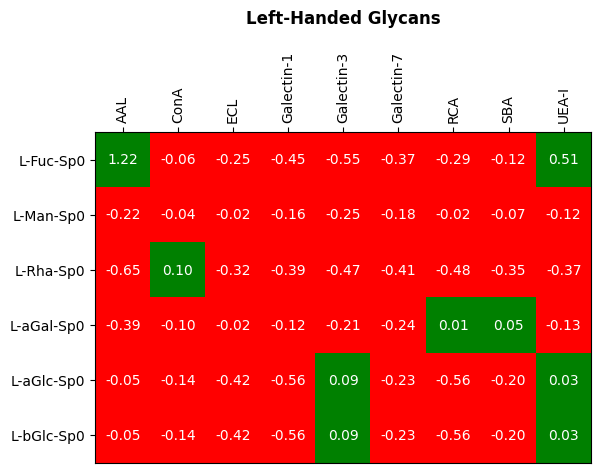

In [26]:
plot_table(left_leor_preds_df, "tables/lectinoracle_preds_lefthanded", "Left-Handed Glycans")

## Right-Handed Predictions

In [27]:
right_leor_preds_df = get_pred_df(protein_df, right_glycan_df)
print(len(right_leor_preds_df))
right_leor_preds_df.head()

54


,glycan,protein,rfu
0,D-aGlc-Sp0,SBA,-0.168248
1,D-bGlc-Sp0,SBA,-0.168248
2,D-Man-Sp0,SBA,-0.167433
3,D-Rha-Sp0,SBA,1.161801
4,D-Gal-Sp0,SBA,-0.158971


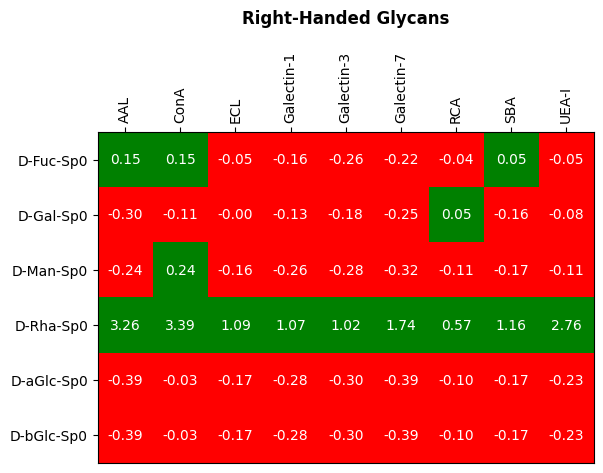

In [28]:
plot_table(right_leor_preds_df, "tables/lectinoracle_preds_righthanded", "Right-Handed Glycans")

## Large Glycans

In [29]:
large_leor_preds_df = get_pred_df(protein_df, large_glycan_df)
print(len(large_leor_preds_df))
large_leor_preds_df.head()

81


,glycan,protein,rfu
0,Man-3,SBA,-0.074417
1,a2-Man,SBA,-0.160774
2,a3-Man,SBA,-0.044696
3,a4-Man,SBA,-0.264915
4,a6-Man,SBA,-0.072742


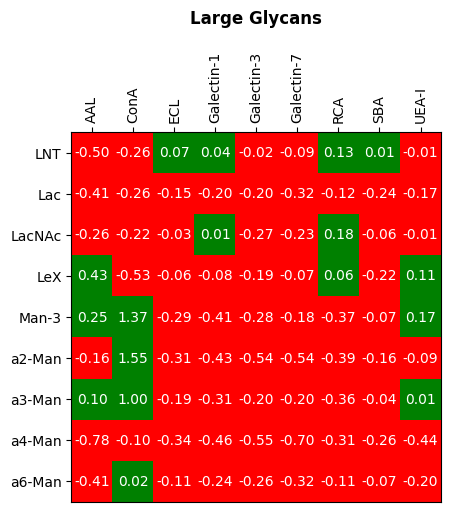

In [33]:
plot_table(large_leor_preds_df, "tables/lectinoracle_preds_large", "Large Glycans")

## Full Dataset

### Load Data

In [34]:
full_glycan_df = pd.read_csv("data/Glycan-Structures.txt", sep="\t")
print(len(full_glycan_df))
full_glycan_df.head()

611


,Name,IUPAC
0,CFG-7-Sp8,Gal(α-Sp8
1,CFG-8-Sp8,Glc(α-Sp8
2,CFG-9-Sp8,Man(α-Sp8
3,CFG-10-Sp8,GalNAc(α-Sp8
4,CFG-10-Sp15,GalNAc(α-Sp15


In [35]:
full_glycan_df["Clean IUPAC"] = get_clean_iupacs(full_glycan_df["IUPAC"])
full_glycan_df.head()

,Name,IUPAC,Clean IUPAC
0,CFG-7-Sp8,Gal(α-Sp8,Gal
1,CFG-8-Sp8,Glc(α-Sp8,Glc
2,CFG-9-Sp8,Man(α-Sp8,Man
3,CFG-10-Sp8,GalNAc(α-Sp8,GalNAc
4,CFG-10-Sp15,GalNAc(α-Sp15,GalNAc


In [36]:
def process_iupacs(glycans):
    for count, iupac in enumerate(glycans):             
        # format sulfate/phosphate groups
        while 'O' in iupac:
            oxygen_idx = iupac.find('O')
            ox_modification_idx = oxygen_idx + 1
            ox_modification = iupac[ox_modification_idx]
            
            end_idx = ox_modification_idx + 1
            while(end_idx < len(iupac) and iupac[end_idx].isnumeric()):
                end_idx += 1
            num_groups = int(iupac[ox_modification_idx + 1: end_idx]) if ox_modification_idx + 1 < end_idx else 1

            positions = []
            start_idx = oxygen_idx
            for i in range(num_groups):
                start_idx -= 1
                position_end = start_idx
                while iupac[start_idx].isnumeric():
                    start_idx -= 1
                positions.insert(0, iupac[start_idx + 1: position_end + 1])
            start_idx += 1
            replacement = "".join(f"{position}{ox_modification}" for position in positions)
            iupac = iupac.replace(iupac[start_idx : end_idx], replacement)
            
        # remove MDPLys spacer
        iupac = iupac.replace('MDPLys', '')
            
        glycans[count] = iupac
    return glycans

In [37]:
full_glycan_df["Clean IUPAC"] = process_iupacs(full_glycan_df["Clean IUPAC"])
full_glycan_df.head()

,Name,IUPAC,Clean IUPAC
0,CFG-7-Sp8,Gal(α-Sp8,Gal
1,CFG-8-Sp8,Glc(α-Sp8,Glc
2,CFG-9-Sp8,Man(α-Sp8,Man
3,CFG-10-Sp8,GalNAc(α-Sp8,GalNAc
4,CFG-10-Sp15,GalNAc(α-Sp15,GalNAc


In [38]:
# list to collect parsed records
records_list = []

for record in SeqIO.parse("data/lectin_sequences.fasta", "fasta"):
    header_parts = record.description.split(" ")

    uniprot_id = header_parts[0].split("|")[1]
    entry_name = header_parts[0].split("|")[2]

    # Get positions of OS= (organism species start)
    try:
        os_index = next(i for i, s in enumerate(header_parts) if s.startswith("OS="))
    except StopIteration:
        os_index = None

    # Protein name is from after entry_name (index 0) up to OS=
    protein_name = " ".join(header_parts[1:os_index])

    # Extract fields safely if present
    os = next((part.split("=")[1] for part in header_parts if part.startswith("OS=")), None)
    ox = next((part.split("=")[1] for part in header_parts if part.startswith("OX=")), None)
    gn = next((part.split("=")[1] for part in header_parts if part.startswith("GN=")), None)
    pe = next((part.split("=")[1] for part in header_parts if part.startswith("PE=")), None)
    sv = next((part.split("=")[1] for part in header_parts if part.startswith("SV=")), None)

    sequence = str(record.seq)

    records_list.append({
        "Accession": uniprot_id,
        "EntryName": entry_name,
        "ProteinName": protein_name,
        "Organism": os,
        "TaxonomyID": ox,
        "Gene": gn,
        "ProteinExistence": pe,
        "SequenceVersion": sv,
        "Sequence": sequence
    })

full_protein_fasta = pd.DataFrame(records_list)

print(len(full_protein_fasta))
full_protein_fasta.head()

83


,Accession,EntryName,ProteinName,Organism,TaxonomyID,Gene,ProteinExistence,SequenceVersion,Sequence
0,A0A089ZWN7,A0A089ZWN7_DATST,Chitin-binding lectin,Datura,4076,dsa-b,2,1,MMRMRHTAISLLALALFFLKVSAKLSLPFYLPANETLGLEVGNTSA...
1,A0A0M3KL30,A0A0M3KL30_9AGAM,Lectin,Agroathelia,39291,l1,1,1,TYKITVRVYQTNPDAFFHPVEKTVWKYANGGTWTITDDQHVLTMGG...
2,A0A0R4I963,A0A0R4I963_CORAP,Helix aspersa agglutinin (HAA),Cornu,6535,None,1,1,ERVQSGKIDCGNDVSWAKVPSDDPGRDNTRELAKNITFASPYCRPP...
3,A0A1L6CAS4,A0A1L6CAS4_SAUVE,Lectin,Sauromatum,4463,None,2,1,MAKLLLFLLPAILGLVVLRSAAAVGTNYLLSDETLNTDGHLKSGDV...
4,A0A218PFP3,A0A218PFP3_WISFL,Lectin,Wisteria,3922,WFA,2,1,MASSQTQNSFSVLLSISLTLFLLLLNKVNSKETTSFVFTRFSPDPQ...


In [39]:
full_protein_df = pd.read_csv("data/Lectin-Sequence-Information.tsv", sep="\t", index_col=0)
full_protein_df = full_protein_df[["Protein Name", "Full protein name", "UniProt ID, etc."]]
full_protein_df = full_protein_df.rename(columns={
    "UniProt ID, etc.": "UniProt ID", 
    "Full protein name": "Name", 
    "Protein Name": "Acronym"
})
print(len(full_protein_df))
full_protein_df.head()

148


,Acronym,Name,UniProt ID
#,,,
1,SNA,Sambucus Nigra Agglutinin,Q41358
2,Anti-LeC,Anti-H(O) lectin 1,P22972
3,UEA I,Ulex Europaeus Agglutinin I,P22972
4,ConA,Concanavalin A,A8WDZ4
5,ECL,Erythrina cristagalli lectin,Q6YD91


In [40]:
full_protein_df["Sequence"] = pd.NA 
nan_counter = 0
for i, row in full_protein_df.iterrows():
    uniprot_id = row["UniProt ID"]
    if pd.isna(uniprot_id):
        nan_counter += 1
        continue
    
    if "GenBank" in uniprot_id:
        uniprot_id = uniprot_id.replace('GenBank', '').strip()
    if "/" in uniprot_id:
        uniprot_id = uniprot_id.split('/')[0].strip()
    if "(" in uniprot_id:
        uniprot_id = uniprot_id.split('(')[0].strip()
        
    matching_rows = full_protein_fasta.loc[full_protein_fasta['Accession'] == uniprot_id].reset_index()
    # if uniprot_id doesnt match Acession value, try EntryName value
    if len(matching_rows) != 1:
        matching_rows = full_protein_fasta.loc[full_protein_fasta['EntryName'] == uniprot_id].reset_index()
        
    if len(matching_rows) != 1:
        print("Protein Name: ", protein_name)
        print("UniProt ID: ", uniprot_id)
        print()  
    elif len(matching_rows) == 1:
        sequence = matching_rows["Sequence"][0]
        full_protein_df.at[i, 'Sequence'] = sequence

print(f"Proteins with sequences: {full_protein_df['Sequence'].notna().sum()} / {len(full_protein_df['Sequence'])}")
print(f"Proteins with sequences (excluding NaN UniProt ID): {full_protein_df['Sequence'].notna().sum()} / {len(full_protein_df['Sequence']) - nan_counter}")

Proteins with sequences: 100 / 148
Proteins with sequences (excluding NaN UniProt ID): 100 / 100


In [41]:
full_protein_df = full_protein_df.dropna(subset=["Sequence"])
print(len(full_protein_df))
full_protein_df

100


,Acronym,Name,UniProt ID,Sequence
#,,,,
1,SNA,Sambucus Nigra Agglutinin,Q41358,MRLVAKLLYLAVLAICGLGIHGALTHPRVTPPVYPSVSFNLTGADT...
2,Anti-LeC,Anti-H(O) lectin 1,P22972,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
3,UEA I,Ulex Europaeus Agglutinin I,P22972,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
4,ConA,Concanavalin A,A8WDZ4,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...
5,ECL,Erythrina cristagalli lectin,Q6YD91,VETISFSFSEFEPGNNDLTLQGAAIITQSGVLQLTKINQNGMPAWD...
...,...,...,...,...
132,Galectin-1,Galectin-1,P09382,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...
137,WT Galectin-8,Wild Type Galectin-8,O00214,MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...
138,CML1,Coprinopsis cinerea lectin 1,B3VS76,MAIFHTGSELFIITRGPGKLTLLTWGGLNNLRSVIGAIPTENTGVT...


### Predictions

In [43]:
full_leor_preds_df = get_pred_df(full_protein_df, full_glycan_df)
print(len(full_leor_preds_df))
full_leor_preds_df.head()

61100


,glycan,protein,rfu
0,CFG-7-Sp8,SNA,0.021081
1,CFG-8-Sp8,SNA,-0.098952
2,CFG-9-Sp8,SNA,-0.086259
3,CFG-10-Sp8,SNA,-0.144731
4,CFG-10-Sp15,SNA,-0.144731


In [44]:
full_leor_preds_df.to_csv("data/full_leor_preds.csv", index=0)